# Word2Vec Algorithm

This is an implementation of the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. 
I'm adapting code from a course in Udacity to our problem. The original code is here: https://github.com/udacity/deep-learning-v2-pytorch/tree/master/word2vec-embeddings 

# Readings and Videos

* An easy introduction to Recurrent Neural Networks: https://www.youtube.com/watch?v=UNmqTiOnRfg
* A nice lecture on LSTM, which is the type of RNN used in this algorithm: https://www.youtube.com/watch?v=iX5V1WpxxkY&t=1s

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al. This explains their choice for subsampling and negative sampling, which makes the algorithm run much faster.
* Visualizing the dataset: https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d



# Loading Data

In [1]:
from project_helper import TweetData
from skipgram import get_batches, cosine_similarity, cosine_similarity_sample, SkipGramNeg, NegativeSamplingLoss

from collections import Counter
import numpy as np
import random

import torch
from torch import nn
import torch.optim as optim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

In [2]:
data = TweetData()

In [3]:
# get list of words
words = data.words
print(words[:30])

['tell', 'jennifer', 'williams', 'whoever', 'that', 'is', 'to', 'read', 'both', 'transcripts', 'of', 'the', 'presidential', 'calls', 'amp', 'see', 'the', 'just', 'released', 'from', 'ukraine', 'then', 'she', 'should', 'meet', 'with', 'the', 'other', 'never', 'trumpers']


In [4]:
print("Total words in Trump's tweets: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words in Trump's tweets: 541042
Unique words: 5603


- Next, we are creating two dictionaries to convert words to integers and back again (integers to words). 
- The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, etc. 

In [5]:
vocab_to_int, int_to_vocab = data.vocab_to_int, data.int_to_vocab
int_words = data.int_words

print(int_words[:30])

[563, 5087, 2287, 3818, 14, 5, 1, 341, 305, 2508, 4, 0, 363, 1234, 20, 110, 0, 35, 529, 41, 906, 226, 115, 61, 663, 17, 0, 129, 71, 3455]


## Subsampling

- This part is a suggestion in Google's paper http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdfText to speed up and improve the algorithm, 
- Some words such as "the", "or", etc appear very often and don't provide much context for neighboring words. By discarding some of them, we can train our network faster and get better results. At the same time, you don't want to discard all of them, as they do provide information about the syntax of tweets. For each word $w_i$ in the training set, we'll discard it with probability given by :

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

Here, $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset. Note that $P(w_i)$ is the probability that a word is discarded. 

In [6]:
def subsampling(threshold, int_words):
    word_counts = Counter(int_words)
    total_count = len(int_words)
    freqs = {word: count/total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
    train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
    return freqs, train_words

## Batches

For each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

In [7]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 2, 2, 2, 3, 3]
y
 [1, 2, 3, 0, 2, 0, 1, 3, 1, 2]


---
## Log-loss function through negative sampling

For every sample we give the network, we train it using the output from the final softmax layer. That means for each sample, we're making very small changes to thousands of weights in the network, which makes training it very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct example, but only a small number of incorrect, or noise, examples. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). 

There are two modifications we need to make. First, since we're not taking the softmax output over all the words, we're really only concerned with one output word at a time. Similar to how we use an embedding table to map the input word to the hidden layer, we can now use another embedding table to map the hidden layer to the output word. Now we have two embedding layers, one for input words and one for output words. Secondly, we use a modified loss function where we only care about the true example and a small subset of noise examples.

$$
- \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

The first term says we take the log-sigmoid of the inner product of the output word vector and the input word vector.

The second term says we're going to take a sum over words $w_i$ drawn from a noise distribution $w_i \sim P_n(w)$. The noise distribution is all those words in Trump's vocabulary that aren't in the context of the input word. We can randomly sample words from our vocabulary to get these. We can choose $P_n(w)$ ro be any distribution, such as a uniform distribution. We could also pick it according to the frequency that each word shows up in our vocabulary. This is called the unigram distribution $U(w)$. The authors found the best distribution to be $U(w)^{3/4}$, empirically. 

Finally, in we take the log-sigmoid of the inner product of a noise vector with the input vector. 

The first term in the loss function pushes the probability that our network will predict the correct word $w_O$ towards 1. In the second term, we're pushing the probabilities of the noise words towards 0.

### Training


In [19]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

# Get our noise distribution
threshold = 1e-4 #lowered threshold as used in Word2Vec algorithm since we have smaller sample
freqs, train_words = subsampling(threshold, int_words)
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

#original is 5, skipgram paper suggests up to 20 for small data sets
N_negative_sampling = 10

# instantiating the model
embedding_dim = 100
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using Negative Sampling Loss as our loss function
criterion = NegativeSamplingLoss() 

# Choosing optimzier
optimizer = optim.Adam(model.parameters(), lr=0.003)

# train for some number of epochs
print_every = 200
steps = 0
epochs = 25


for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], N_negative_sampling)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/25
Loss:  11.171263694763184
would | truman, justify, centers, autism, ambassador
democrats | allen, struck, awareness, partisan, gangs
if | wedding, setting, jerome, jeffress, resigned
and | omar, meetings, need, opioid, streaming
again | outside, are, worse, quite, trans
or | gift, memory, susteren, performance, fiction
us | strange, investments, deals, lisa, immigrants
was | henry, patrol, making, official, border
plans | endure, match, done, cabinet, disappeared
marco | waiting, deserve, accepting, lead, cant
peace | setup, enthusiastic, hopes, average, arriving
chairman | schiff, secretary, solar, pipeline, kravis
group | ken, crane, news, scheme, sides
jeff | likes, lead, immediately, animal, battle
statements | perry, official, brilliantly, midas, meltdown
amnesty | through, borders, celebrate, along, pitcher
...

Epoch: 1/25
Loss:  5.8455939292907715
from | bad, unemployed, diamond, mitt, guy
big | down, delusional, dont, hits, problem
much | attack, duty, dont, primar

china | countries, s, giving, hire, for
been | and, thank, we, amp, crazy
get | in, president, winners, on, or
in | people, it, going, race, great
why | that, report, they, been, a
marco | deserve, wonder, cant, lead, waiting
spend | promised, be, answer, qualified, pretend
strength | no, work, medicaid, obama, who
ahead | on, in, be, awards, today
arrived | exciting, intl, true, spectacular, done
african | dont, big, leaving, november, lots
director | led, hq, comey, crowds, between
midas | successful, success, boeing, considered, launched
...

Epoch: 7/25
Loss:  3.204618215560913
not | the, to, that, it, as
democrats | there, dems, they, many, witch
he | his, called, is, running, no
many | are, it, president, election, his
them | are, their, keep, our, drugs
at | my, great, on, pm, interviewed
than | more, far, they, story, got
my | on, at, be, great, will
created | he, citizens, terrific, mission, entrepreneurship
opec | oil, prices, management, moved, allow
las | all, times, celebr

if | but, do, use, leverage, must
can | unable, take, that, because, not
but | and, if, any, have, it
will | i, america, tonight, you, make
never | that, it, didnt, easily, beat
people | are, of, to, be, amp
from | now, are, minister, two, area
not | the, that, its, as, instead
biased | media, news, nbc, dishonest, poorly
steel | industry, jobs, buy, companies, plant
bless | god, families, victims, celebrate, sacrifice
advantage | tariff, resolute, substantially, deals, reach
troops | syria, pouring, them, isis, sending
local | officials, heed, god, enforcement, bless
disgusting | congresswomen, moreland, age, horrible, should
ice | patrol, border, men, suspect, criminals
...

Epoch: 13/25
Loss:  2.860750913619995
what | dont, it, vince, often, go
me | so, look, negative, did, crooked
time | on, prices, waste, it, staged
he | his, called, transcripts, obama, is
your | skills, focus, yourself, negotiation, keep
have | that, but, and, any, of
as | not, to, have, problem, i
trump | via, d

of | the, in, an, be, to
at | on, pm, be, tonight, forward
his | he, him, running, guess, campaign
we | our, have, country, nation, feds
big | i, be, tuesday, sold, that
do | you, necessary, if, work, something
with | on, and, at, the, discussing
biden | joe, sleepy, hunter, actual, nor
demand | overwhelmingly, did, address, should, tactics
amnesty | opposes, immigration, oppose, lottery, grant
african | hispanic, blacks, inner, gains, pentagon
found | glad, information, unhappy, australia, requested
dopey | karl, loser, losers, overrated, stupid
xi | un, jong, kim, jinping, korean
hits | hit, index, numbers, beto, low
...

Epoch: 18/25
Loss:  2.8664865493774414
or | is, other, that, and, own
america | make, together, again, tradition, movement
by | the, campaign, a, and, i
china | chinese, currency, agreed, deficit, stimulus
being | making, bravery, of, new, bridge
doing | so, there, determination, many, focus
as | not, to, held, washington, others
are | and, our, fighting, their, peo

on | at, be, interview, my, and
at | on, be, tonight, pm, forward
different | that, this, the, called, been
expected | crowd, going, jan, crowds, enthusiastic
college | applications, electoral, release, records, returns
cover | daily, havent, accurately, meaning, false
dopey | karl, losers, loser, rove, writer
victims | prayers, praying, families, injured, shooting
plans | options, near, sterling, medicare, plan
player | gary, carlos, soccer, brady, villa
...

Epoch: 23/25
Loss:  2.7670676708221436
i | will, that, be, big, you
will | i, to, see, you, be
but | have, is, and, if, able
their | they, into, are, and, country
thank | you, hampshire, evening, arizona, join
people | are, so, of, to, in
t | didn, couldn, they, don, doesn
our | country, nation, we, are, military
host | links, honor, river, thrilled, rooms
goes | expenses, lightweight, drain, rent, today
room | star, celebrity, w, luxurious, board
either | quickly, successful, problem, or, but
biden | sleepy, joe, hunter, pressur

# Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.
Wiki on T-SNE, a bit complicated! https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [20]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

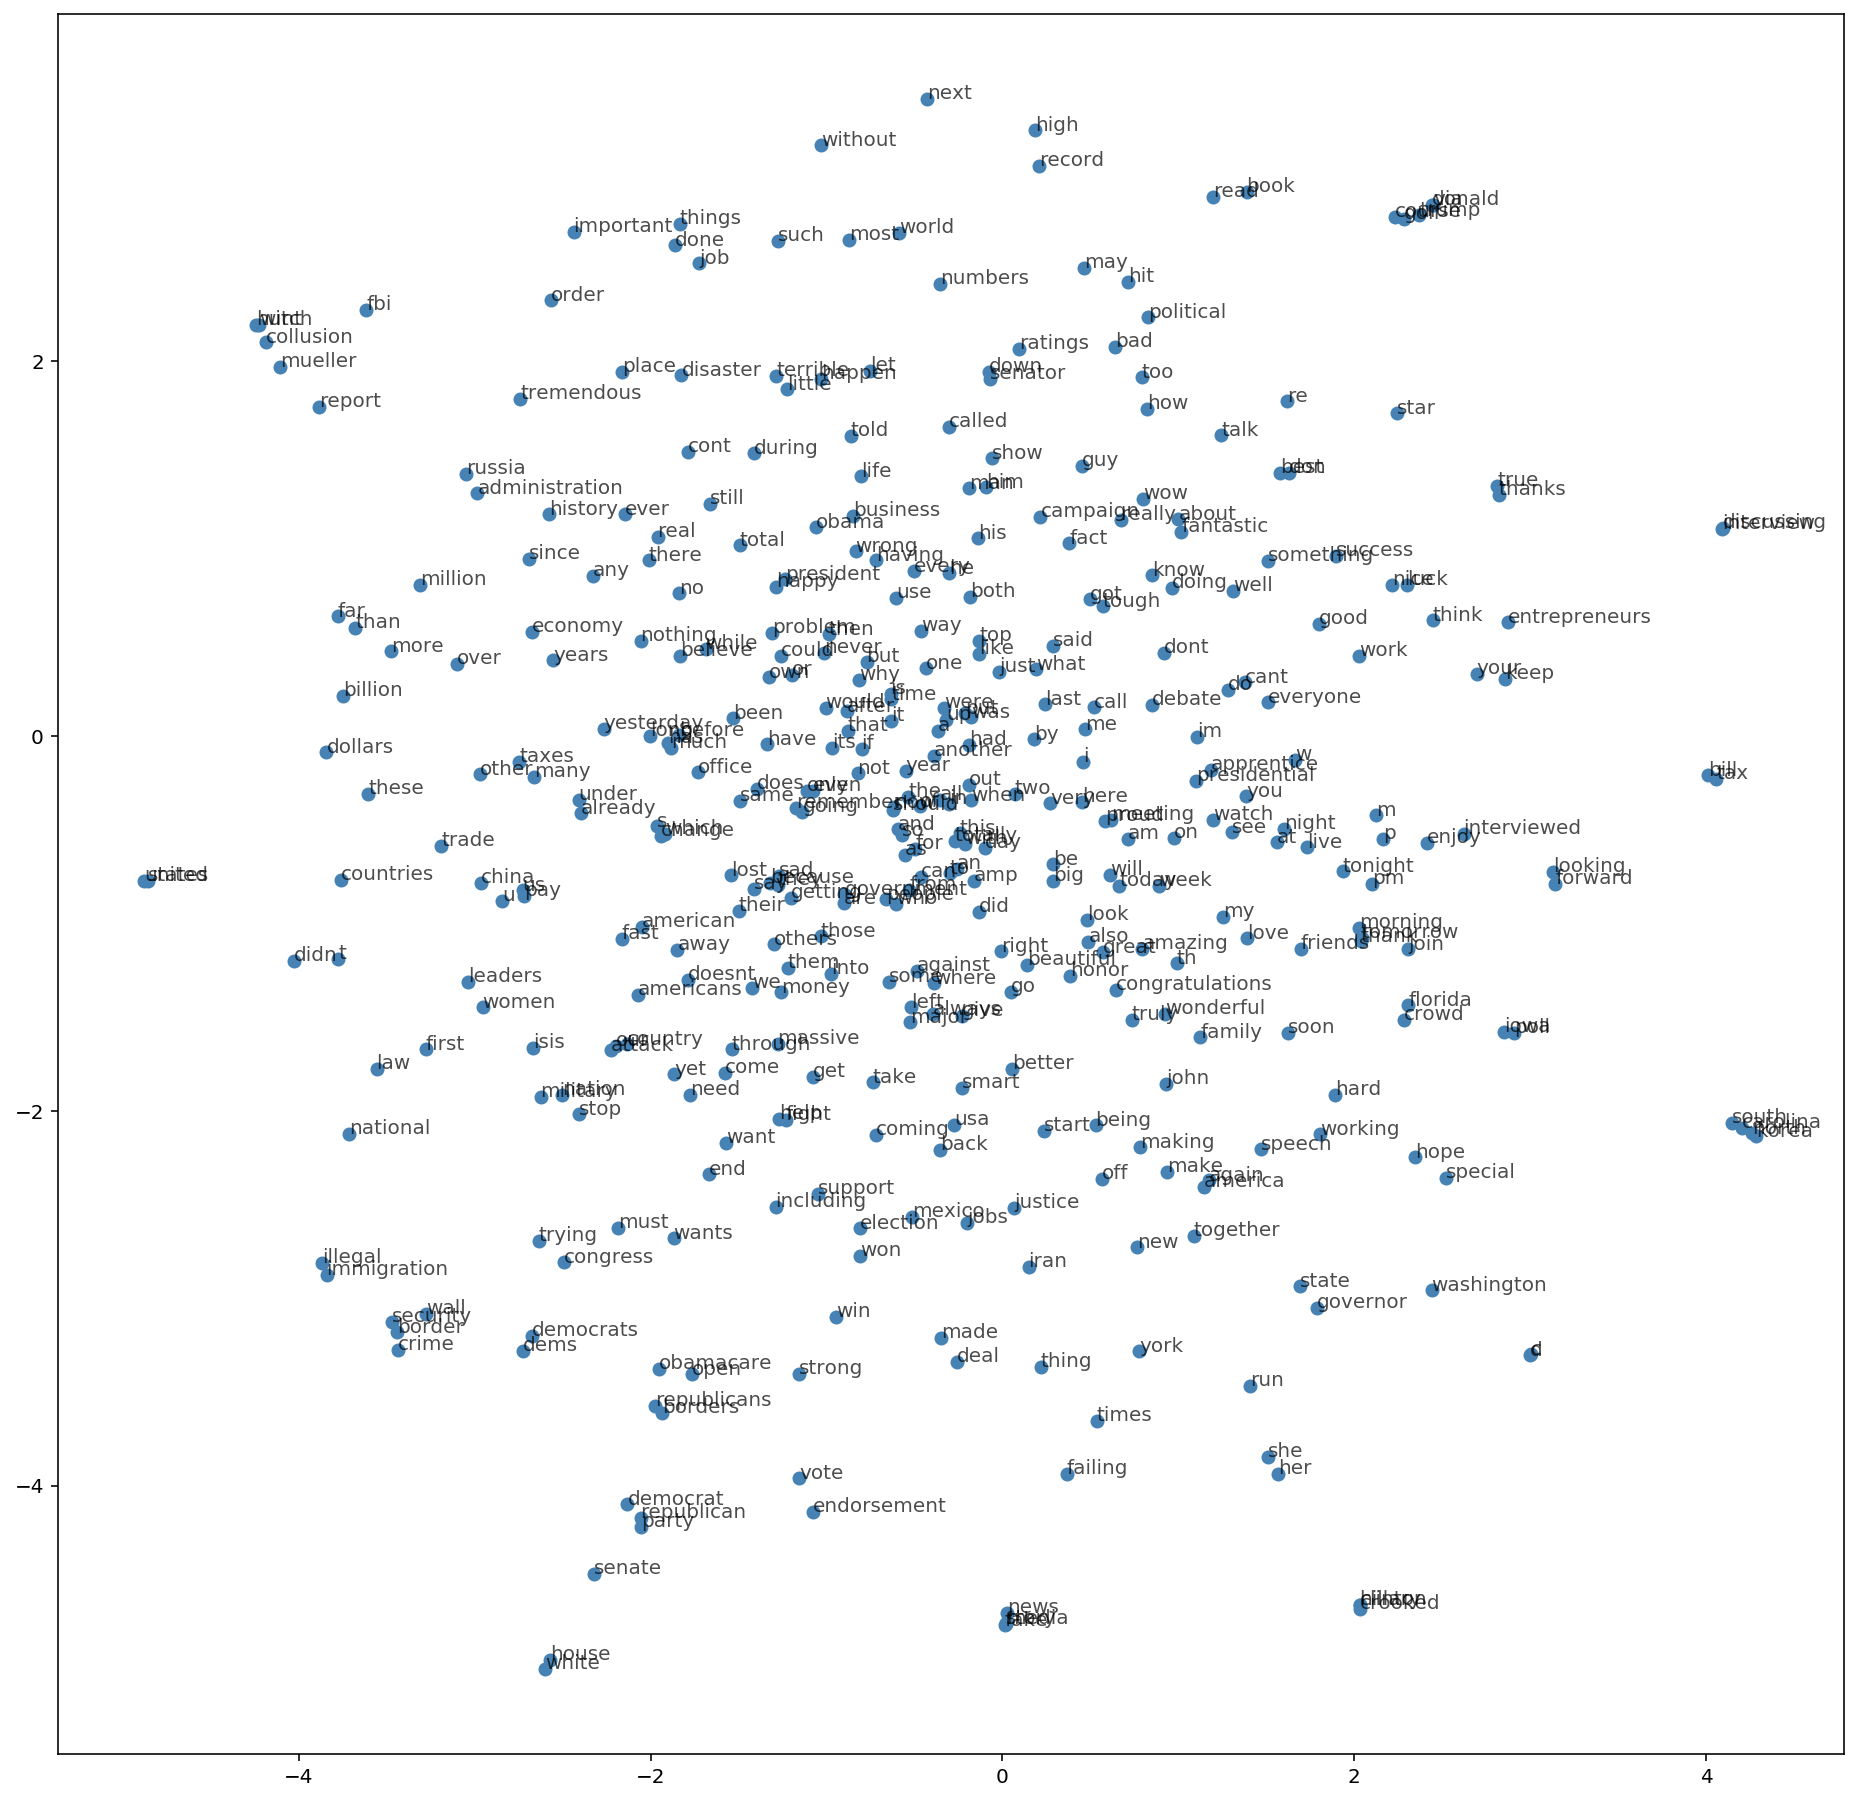

In [21]:
viz_words = 400
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [22]:
def word_similarities(word, num):
    word_int = vocab_to_int[word]
    valid_examples, valid_similarities = cosine_similarity_sample(model.in_embed, [word_int])
    closest_idxs = valid_similarities.topk(num)
    closest_words = [int_to_vocab[int(a)] for a in closest_idxs.indices[0]]
    return closest_words

In [23]:
word_similarities('tariff',20)

['tariff',
 'tariffs',
 'companies',
 'dealers',
 'advantage',
 'cooperation',
 'salvador',
 'mexico',
 'tariffed',
 'agricultural',
 'barriers',
 'products',
 'harley',
 'guatemala',
 'goods',
 'currently',
 'agreed',
 'steel',
 'eu',
 'cars']

In [24]:
keys = ['collusion', 'hillary', 'hotel', 'democrats', 'campaign', 'fed', 'china', 'mexico', 'tariffs']


In [25]:
# Code adapted from 
# https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
def get_clusters(keys, num, embeddings):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embed_sub = []
        words = []
        for similar_word in word_similarities(word,20):
            words.append(similar_word)
            embed_sub.append(embeddings[vocab_to_int[similar_word],:])
        embedding_clusters.append(embed_sub)
        word_clusters.append(words)
    return embedding_clusters, word_clusters
    

In [26]:
embedding_clusters, word_clusters = get_clusters(keys,10,embeddings)

In [27]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

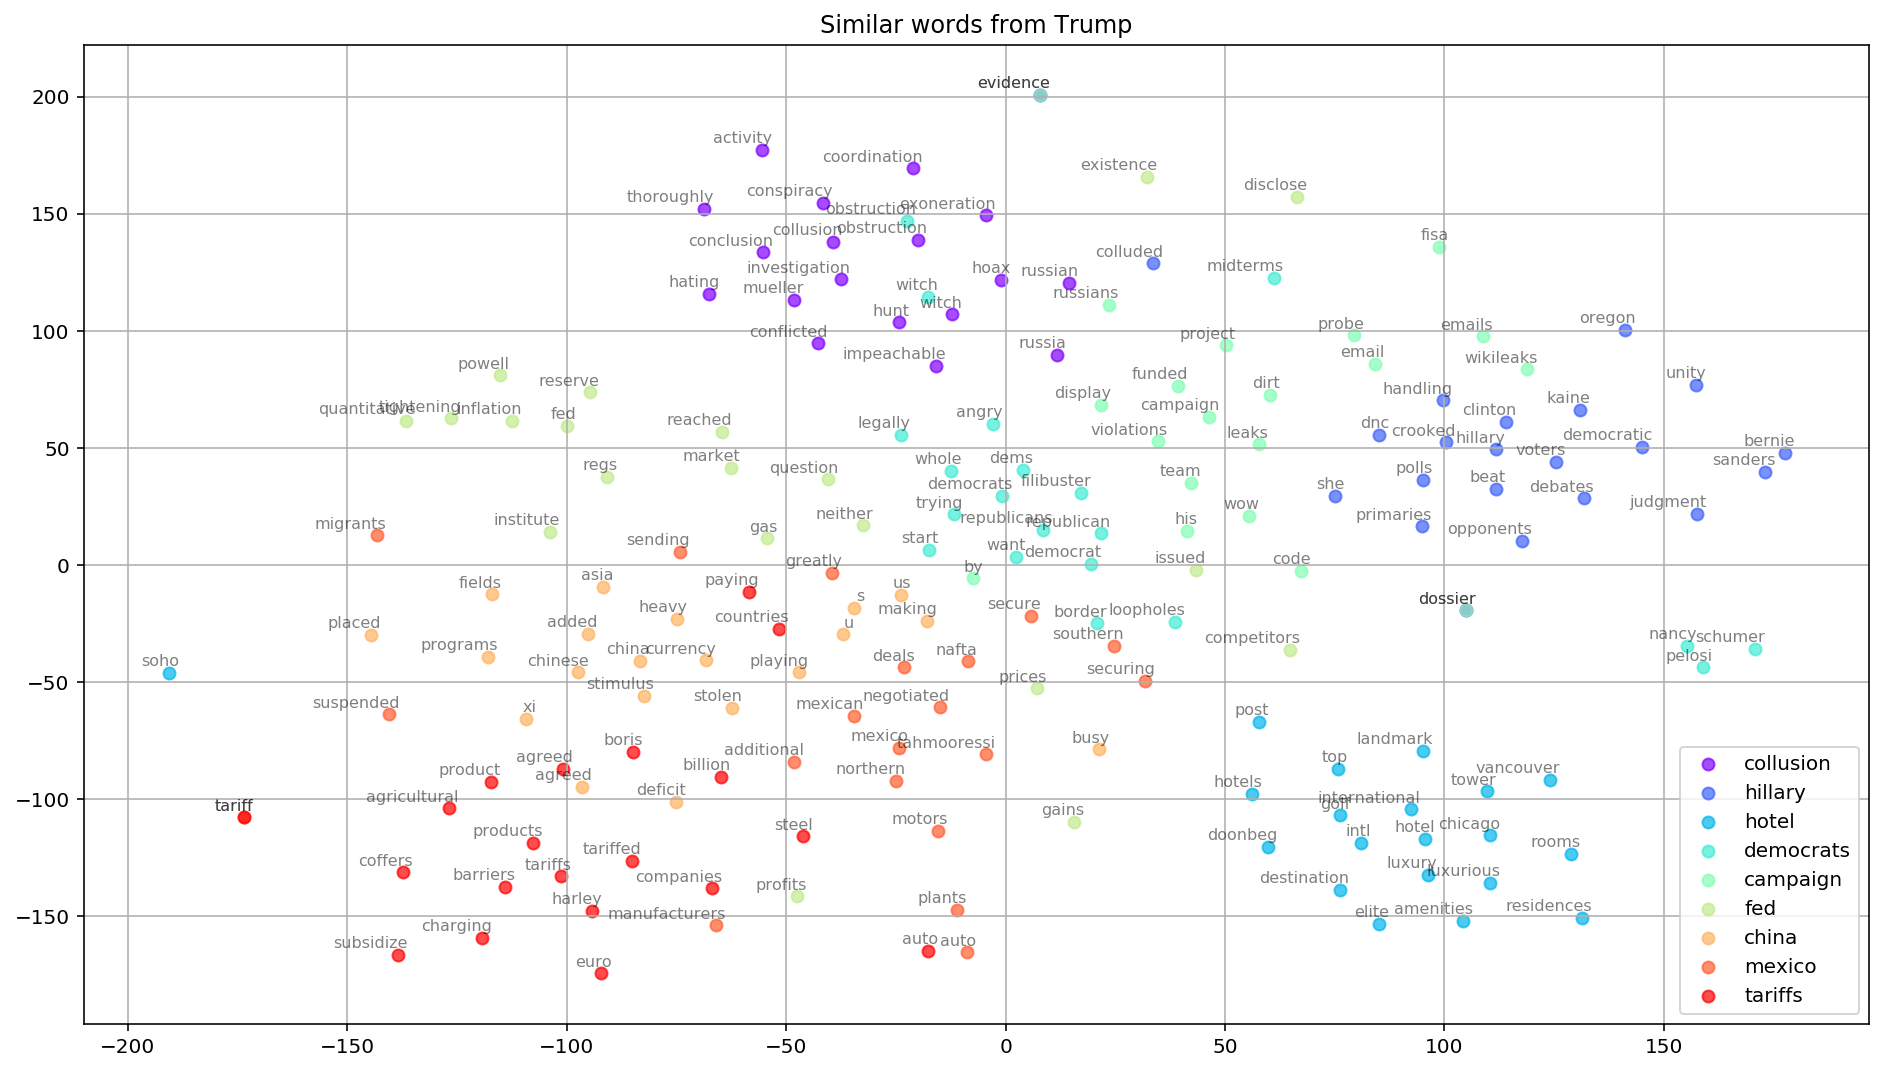

In [28]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Trump', keys, embeddings_en_2d, word_clusters, 0.7,
                        'results/similar_words.png')
